<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/Visualizing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualizing imputed dataset (imputed by crude backfilling)


In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/df_imputed_week_shift.csv", index_col = 0, parse_dates = True)

In [0]:
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

In [0]:
import numpy as np
def resample_df(df, freq = "D", method_speed = np.mean, method_flow = np.sum):
    copied = df.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow})
    return copied

In [0]:
df_D =  resample_df(df, method_speed = np.mean)

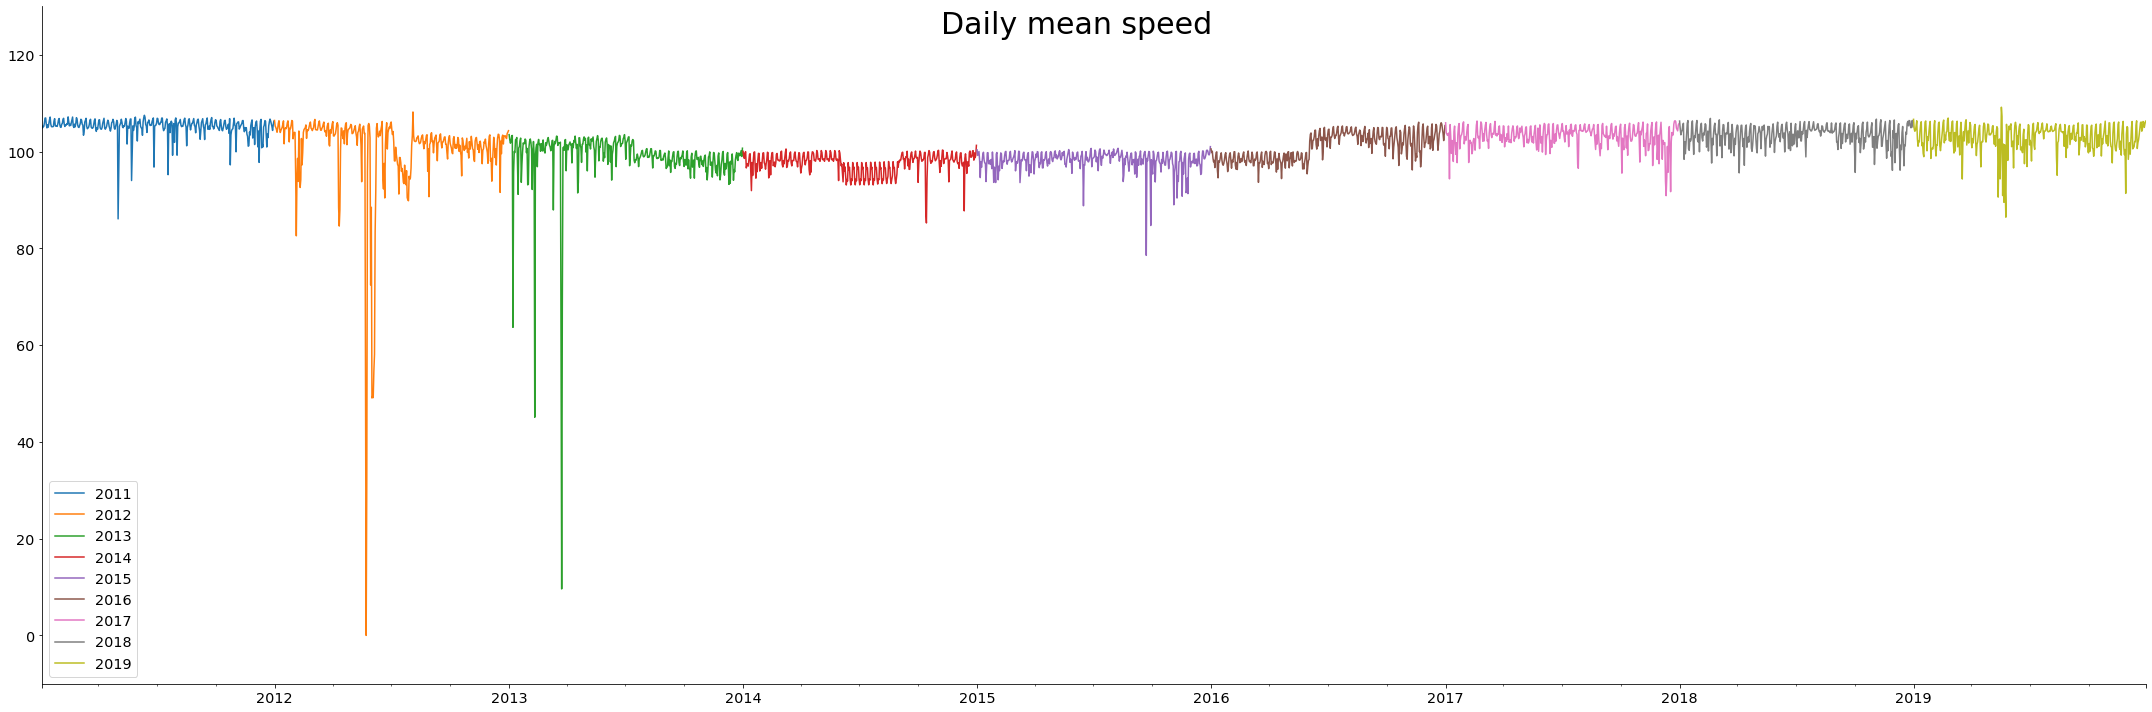

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize = (30, 10), sharey = True)
fig.suptitle('Daily mean speed', fontsize = 30)
ax.set_ylim(-10, 130)
for i, year in enumerate(range(2011, 2020)):
    df_D[df_D.index.year == year]['speed'].plot(ax = ax, label = year)
ax.legend()
sns.despine()
plt.tight_layout()

In [0]:
fig.savefig('plots/Daily_speed_mean.png', dpi = 600)